openCV를 이용한 글자 인식

In [ ]:
# 데이터 위치: https://www.motorgraph.com/news/photo/202302/31685_99238_2844.jpg

In [1]:
import cv2
print(cv2.__version__)

4.8.1


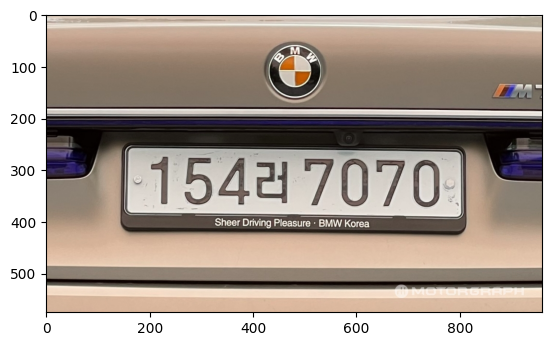

In [2]:
import numpy as np
import matplotlib.pyplot as plt

img=cv2.imread('./car.jpg',cv2.IMREAD_UNCHANGED)
height, width, channel = img.shape
# cv2.imshow('a',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(img)

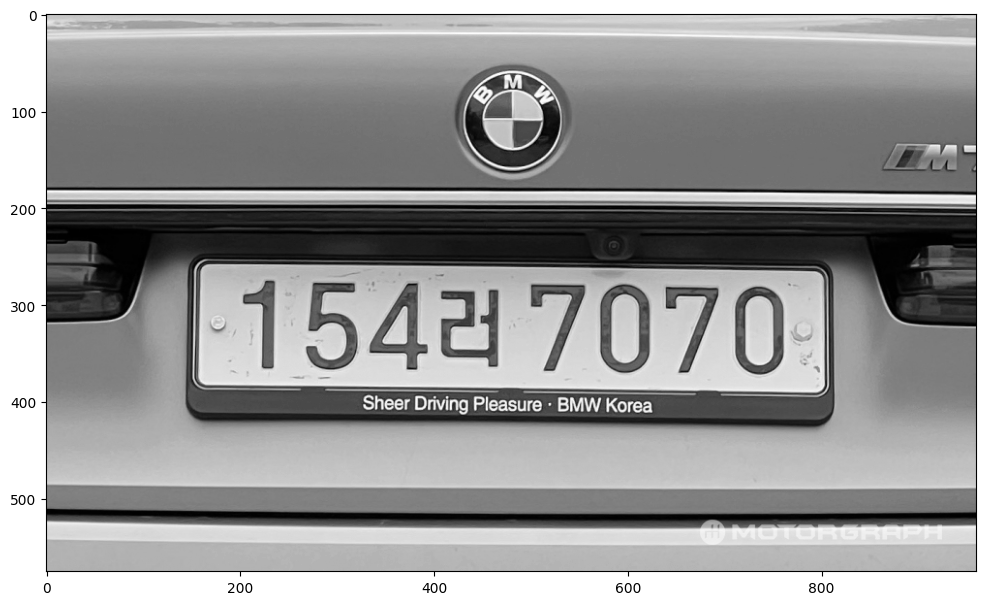

In [9]:
# 회색으로 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

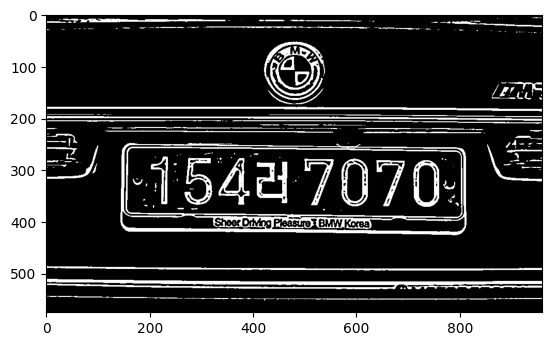

In [10]:
# 가우시안 블러=노이즈 삭제
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
# thresjolding
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)
plt.imshow(img_blur_thresh, cmap='gray')

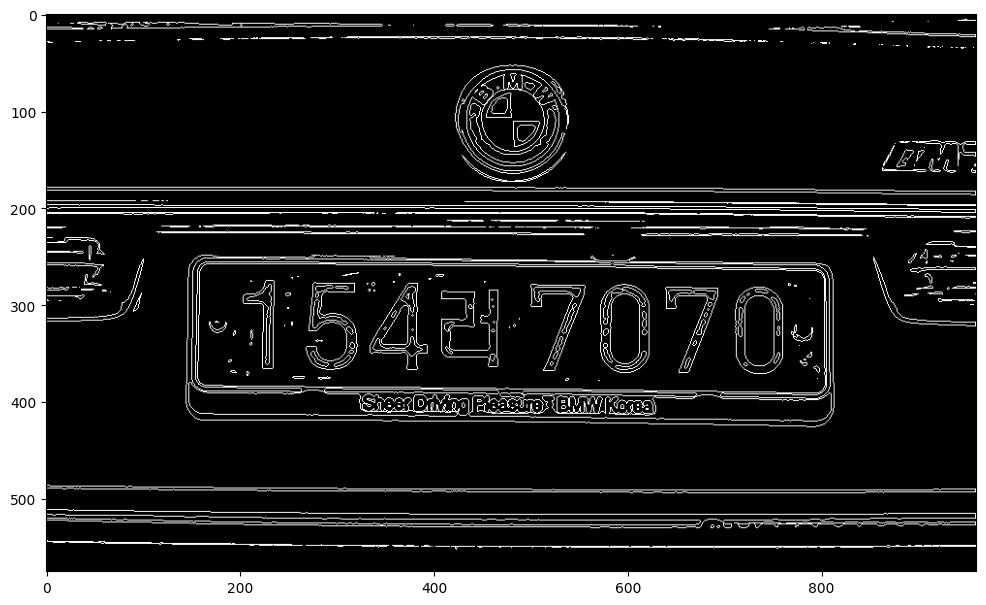

In [11]:
# contours: 동일한 색과 강도를 가진 경계선을 연결한 선
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

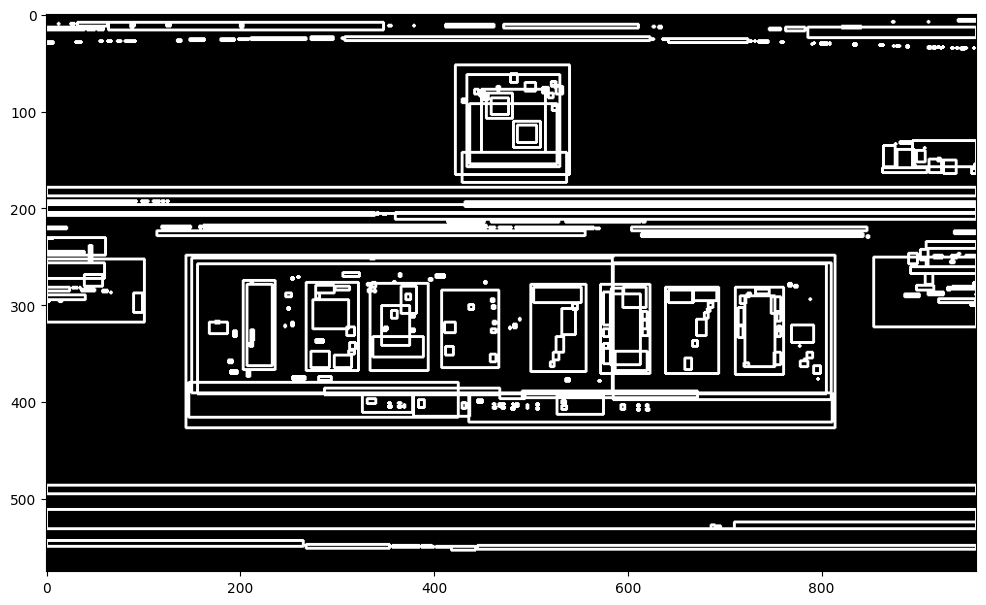

In [12]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8) # 이미지와 동일한 크기 빈 공간

contours_dict = [] # 각 contours의 위치정보 저장

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

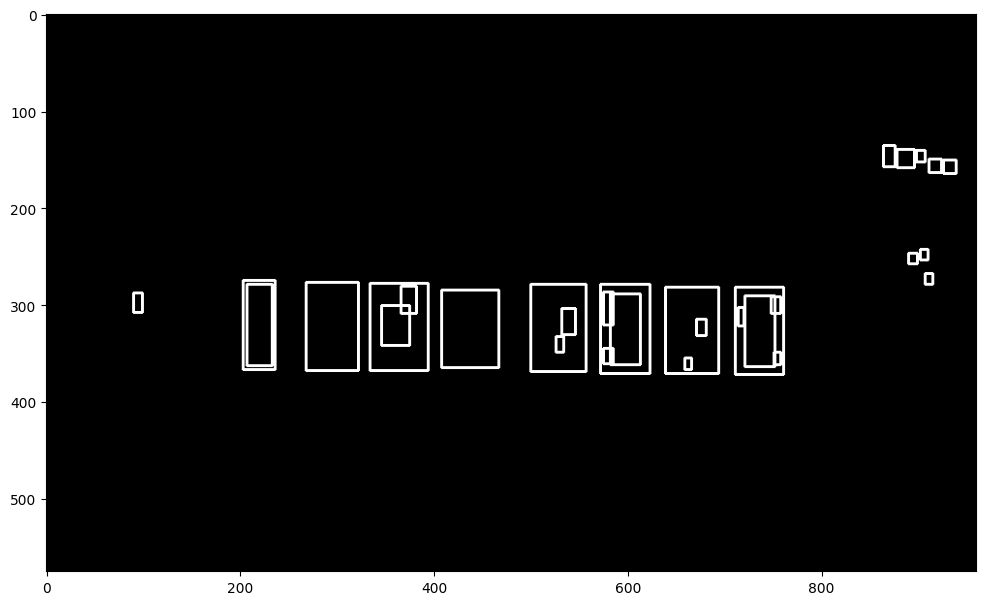

In [13]:
# 일정 비율을 가지고 있는 번호판 숫자의 특성을 이용해 추려낸다.

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.1, 1.0 # 최소비율, 최대비율

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h'] # 너비와 높이로 비율을 구한다.

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

3.4212192764293063
5.538637532790516
8.583621480113948
70.20112364547508
19.403625737855755
41.66614933846343
7.451683920327195
33.763055740655226
24.356391252796385
28.64133023383634
34.64094751191629
6.329120097832629
9.090276920822323
24.824554769183347
83.38653951768524
12.885786139883793
5.165241044995761
28.979707697928777
15.435861887466807
7.254911751799747
5.980599524763449
5.159442684006781
19.397812448558224
25.06419508978456
24.79751881773166
36.93774341580688
38.659808254090095
41.72232404780973
43.29214558987895
45.88349477820116
3.4212192764293063
0.8208002858949207
3.6954852766720188
22.177937118609147
10.000395978916059
48.90854429445946
4.932087428264855
88.4377750831576
57.264773727892404
10.817833584841013
16.442855249955567
4.979105843998313
5.495768537498554
57.01147838636545
18.239400846651154
9.034476035766012
3.6931077696497563
10.993772583237364
7.934796765812691
4.757570293110555
4.107769492880095
3.6896658057290503
27.652815017462082
36.342448522834125
35.23

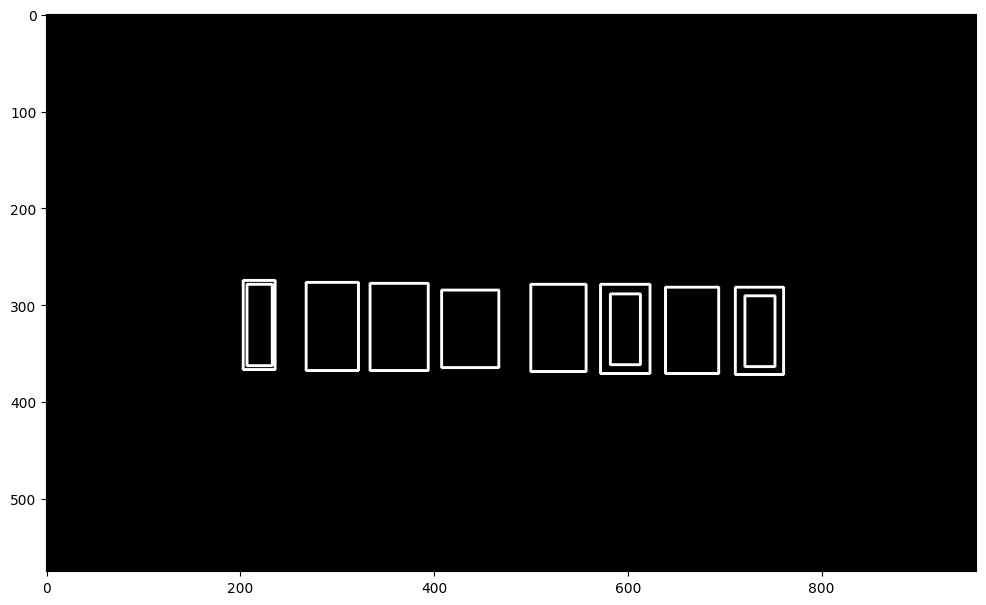

In [14]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3


def find_chars(contour_list):
    matched_result_idx = []# 조건에 맞는 인덱스

    angles=[]
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:# 같은 사각형은 그대로 패스
                continue

            dx = abs(d1['cx'] - d2['cx']) # 각 사각형의 중앙선끼리 차이
            dy = abs(d1['cy'] - d2['cy']) # 각 사각형의 중앙 높이끼리 차이

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # 대각선 방향

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0: # 같은 높이에 있다.
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # 높이차이/너비차이의 역탄젠트를 하면 각도가 나온다.
                print(angle_diff)
                angles.append(angle_diff)
                # 휘어진 사진이다.
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) # 넓이차이
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비차 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이차 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)# 조건에 맞지 않은 사각형의 정보를 인덱스로 가지고 온다.

        recursive_contour_list = find_chars(unmatched_contour)# 재귀. 또 찾아온다.

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    # from scipy.stats import mode
    # print("평균",np.mean(angles),"중앙값",np.median(angles),"최빈값",mode(list(map(int,angles)))) # 왜 두번 출력?

    return matched_result_idx # 조건에 맞는 데이터 인덱스만 가지고 온다.

result_idx = find_chars(possible_contours)
# print("뽑아낼 idx",result_idx)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list)) # 조건에 맞는 데이터만 가지고 온다.

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result: # 맞는 데이터만 저장됨.
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [15]:
matched=matched_result[1] # 0: 작은거, 1: 큰거
print(len(matched))
print(len(matched_result[0]))

8
3


In [ ]:
# ------------여기서부터 다시

In [4]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'D:/Users/skadl/StartProgram/Tesseract-OCR/tesseract.exe'


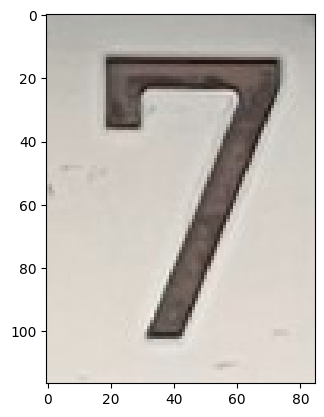

In [6]:
from PIL import Image
plt.imshow(Image.open('text.jpg'), cmap='gray')
print(pytesseract.image_to_string(Image.open('text.jpg')))
# JAS HRY, 445. no, probl

# GALS OFL|Of. 209. Okay. no matter
print(pytesseract.image_to_string(Image.open('text.jpg'), config=('-l kor --oem 3 --psm 11'))) 
# 가게를 봐줘, 445. 00, 07060!

# 무것도 아니야. 209. 01<3/. 0ㅇ 10346
print(pytesseract.image_to_string(Image.open('text.jpg'), config=('-l kor+eng --oem 3 --psm 11')))
# 가게를 봐줘, 445. no, probl

# FAS 아니야. 209. Okay. no matter

print(pytesseract.image_to_string(Image.open('test.jpg'), config=('-l kor --oem 3 --psm 11')))# 아무것도 나오지 않음.
cropped=cv2.imread('test.jpg',cv2.IMREAD_UNCHANGED)
plt.imshow(cropped, cmap='gray')


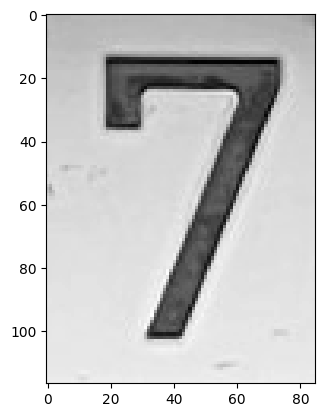

In [48]:

gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap='gray')

In [49]:
pytesseract.image_to_string(gray, config=('-l eng --oem 3 --psm 11')) # gray안됨

''

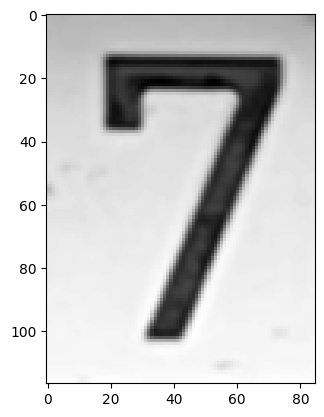

In [50]:
img_result = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
plt.imshow(img_result, cmap='gray')

In [51]:
pytesseract.image_to_string(img_result, config=('-l kor --oem 3 --psm 11')) 

''

''

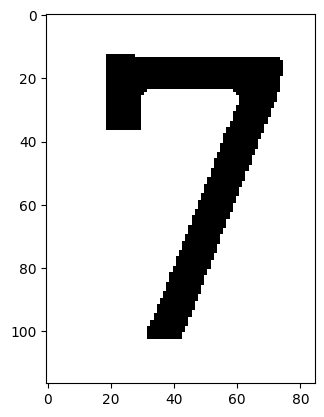

In [34]:
door, img_thresh = cv2.threshold(gray, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(img_thresh, cmap='gray')
pytesseract.image_to_string(img_thresh, config=('-l kor --oem 3 --psm 11')) 

In [7]:
# a, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# 이미지, 문턱값, 보다 클때 적용되는 최대값, 스타일
# 현재: 임계값 넘으면 value, 못넘으면 0-> 오츠의 알고리즘으로 최적의 임계값을 살핀다.
# a: 문턱값

# img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0)) 
# 가장자리에 투명 이미지가 추가된다.->이미지를 크게 할 용도

결론: openCV는 꺾인 7을 인식하지 못함.(==다른 폰트를 인식하지 못함.)

해결방법: .traindata을 다른 폰트로 학습시킨 것을 사용하면 될 것 같으나, 찾는데 어려움이 있을 것으로 예상됨. 